# NZU price dynamics 

Assuming price dynamics follows [geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion), it can be simulated using a discrete-time Markov chain Monte Carlo (MCMC) by repeatedly applying the following recurrence relation, 

$$
p^{(t+1)} = p^{(t)}\exp(d+\xi), 
$$

where $t \in \{0,1,2,\dots\}$ indexes timesteps (which could represent days, months, or years), $d$ is a constant drift parameter, and $\xi$ is a normally distributed random variable, i.e. $\xi \sim \mathcal{N}(0,\sigma)$, with the standard deviation $\sigma$ (and variance $\sigma^{2}$) determining price volatility. Note that the underlying assumption here is that price will move in steps that are lognormally distributed, i.e.

$$
r^{(t+1)} := \ln\left(\frac{p^{(t+1)}}{p^{(t)}}\right) \sim \mathcal{N}(d,\sigma).
$$

The two parameters, $d$ and $\sigma$, can be inferred from data on past prices, i.e. a historical dataset $P_{H} = \{p^{(t)}, p^{(t-1)}, \dots, p^{(t-M)}\}$, from which $R_{H} = \{r^{(t)}, \dots, r^{(t-M+1)}\}$ can be calculated. The latter set of values will have an arithmetic mean $\bar{r}$ and variance $\sigma_{r}^{2}$, calculated
using 
$$
\bar{r} = \frac{1}{M}\sum_{i=0}^{M-1}r^{(t-i)} \quad \mathrm{and} \quad \sigma_{r}^{2} = \frac{1}{M-1} \sum_{i=0}^{M-1} (r^{(t-i)} - \bar{r})^{2},
$$

and, according to [this Investopedia article](https://www.investopedia.com/terms/m/montecarlosimulation.asp), the drift parameter can then be calculated using the formula

$$
d_{r} = \bar{r} - \frac{\sigma_{r}^{2}}{2}. 
$$

This formula seems similar to the "risk-neutral drift" in [these notes on geometric Brownian motion](http://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-GBM.pdf).

A simulated Markov chain $i$ starting from $p^{(0)}$ at $t=0$ should end up at a value
$$
p_{i}^{(N)} = p^{(0)} \exp\left(Nd + \sum_{t=1}^{N}\xi_{n}\right)
$$
at $t=N$. Repeating the simulation starting with the same initial condition will produce another Markov chain $j$ with a different endpoint, i.e. $p_{j}^{(N)} \neq p_{i}^{(N)}$. Repeating the simulation sufficiently many times should reveal that the endpoints will be lognormally distributed with the mean value of $Nd_{r}$ and standard deviation of $\sqrt{N}\sigma_{r}$, i.e.

$$
\ln\left(\frac{p^{(N)}}{p^{(0)}}\right) \sim \mathcal{N}(Nd_{r},\sqrt{N}\sigma_{r}).
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#source='./nzu-month-price.csv'
source='https://github.com/theecanmole/nzu/raw/master/nzu-month-price.csv'
df = pd.read_csv(source, parse_dates=[0])

In [3]:
date = list(df['month'])
price = list(df['price'])

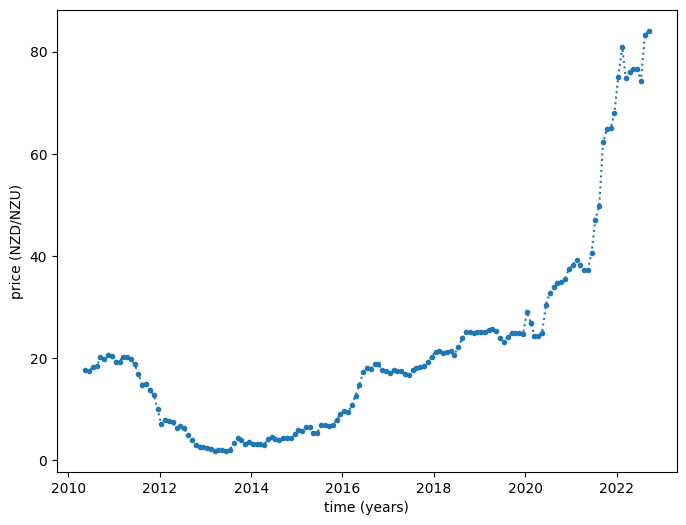

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(date, price, linestyle=':', marker='.')
ax.set_xlabel('time (years)')
ax.set_ylabel('price (NZD/NZU)')
plt.show()

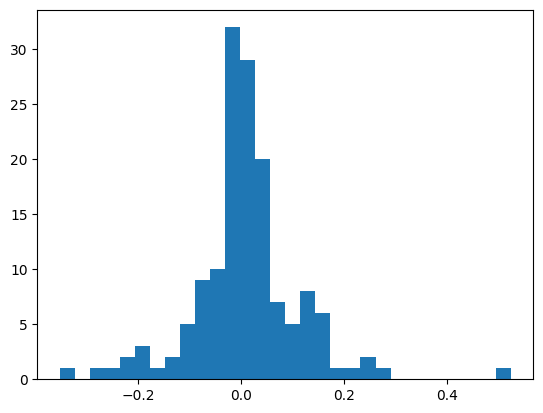

In [9]:
logreturns = [np.log(price[i]/price[i-1]) for i in range(1,len(price))]
plt.hist(logreturns, bins=30)
plt.show()

Calculate the average, variance, standard deviation, and drift.

In [10]:
ave = sum(logreturns)/len(logreturns)
var = sum([(r-ave)**2 for r in logreturns])/(len(logreturns)-1)
drift = ave - 0.5*var
sd = np.sqrt(var)

In [11]:
np.random.seed(seed=1)
projections = []
for i in range(20000):
    projection = [price[-1]]
    for j in range(60):
        rand = np.random.normal(loc=0.0, scale=sd)
        pnew = projection[-1]*np.exp(drift + rand)
        projection.append(pnew)
    projections.append(projection)

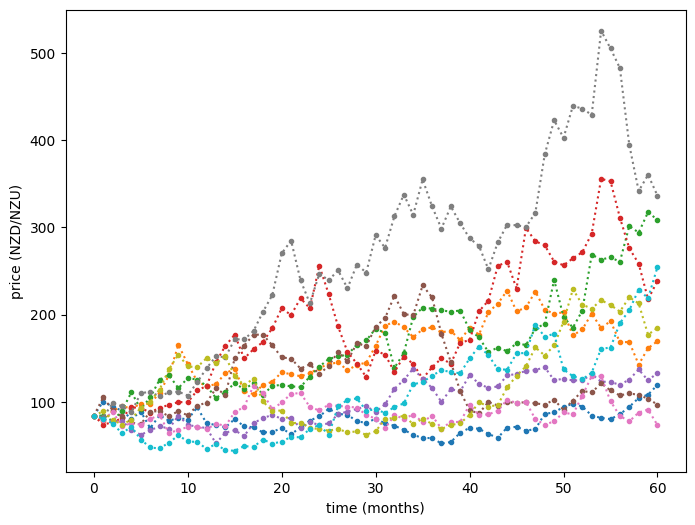

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
    ax.plot(projections[i], linestyle=':', marker='.')
ax.set_xlabel('time (months)')
ax.set_ylabel('price (NZD/NZU)')
plt.show()

In [13]:
logreturns12 = [np.log(proj[12]/proj[1]) for proj in projections]
logreturns24 = [np.log(proj[24]/proj[1]) for proj in projections]
logreturns60 = [np.log(proj[60]/proj[1]) for proj in projections]

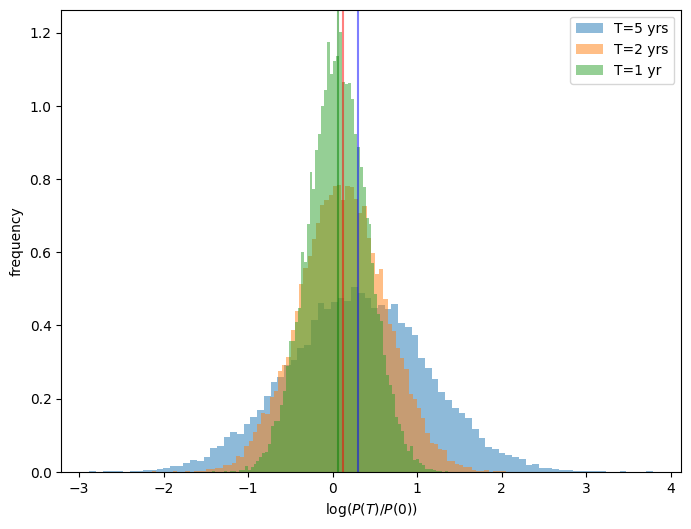

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('$\log(P(T)/P(0))$')
ax.set_ylabel('frequency')
ax.hist(logreturns60, bins='auto', alpha=0.5, density=True, label='T=5 yrs')
ax.hist(logreturns24, bins='auto', alpha=0.5, density=True, label='T=2 yrs')
ax.hist(logreturns12, bins='auto', alpha=0.5, density=True, label='T=1 yr')
ax.axvline(x=60*drift, color='b', alpha=0.5)
ax.axvline(x=24*drift, color='r', alpha=0.5)
ax.axvline(x=12*drift, color='g', alpha=0.5)
ax.legend()
plt.show()

In [15]:
proj_date=[date[-1]]
proj_price=[price[-1]]
proj_price_hi=[price[-1]]
proj_price_lo=[price[-1]]
for m in range(1,61):
    proj_date.append(date[-1]+pd.offsets.DateOffset(months=m))
    proj_price.append(price[-1]*np.exp(m*drift))
    proj_price_hi.append(price[-1]*np.exp(m*drift+np.sqrt(m)*sd))
    proj_price_lo.append(price[-1]*np.exp(m*drift-np.sqrt(m)*sd))

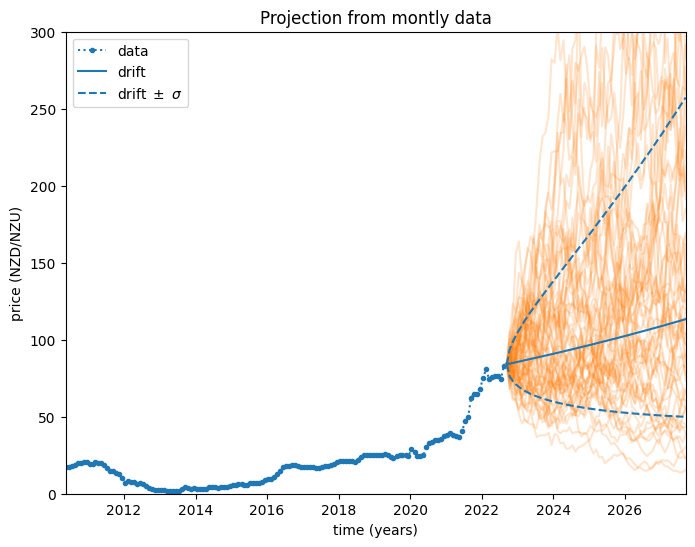

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(date, price, linestyle=':', marker='.', label='data')

for i in range(60):
    ax.plot(proj_date, projections[i], 'C1', alpha=0.2)
    
ax.plot(proj_date, proj_price, 'C0', label='drift')
ax.plot(proj_date, proj_price_lo, 'C0--', label='drift$~\pm~\sigma$')
ax.plot(proj_date, proj_price_hi, 'C0--')
ax.set_ylim(0, 300)
ax.set_xlim(date[0],proj_date[-1])
ax.set_xlabel('time (years)')
ax.set_ylabel('price (NZD/NZU)')
ax.set_title("Projection from montly data")
plt.legend()
plt.show()

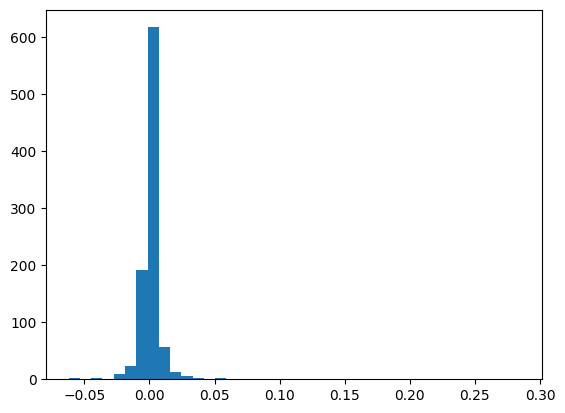

0.284293387406264

In [58]:
source='./commtrade-price.csv'
df = pd.read_csv(source, parse_dates=[0])
spot_date = list(df['date'])
spot_price = list(df['price'])
spot_logreturns = [np.log(spot_price[i]/spot_price[i-1]) for i in range(1,len(spot_price))]
plt.hist(spot_logreturns, bins=40)
plt.show()
max(spot_logreturns)

In [59]:
spot_ave = sum(spot_logreturns)/len(spot_logreturns)
spot_var = sum([(r-spot_ave)**2 for r in spot_logreturns])/(len(spot_logreturns)-1)
spot_drift = spot_ave - 0.5*spot_var
spot_sd = np.sqrt(spot_var)

In [60]:
proj_spot_date=[spot_date[-1]]
proj_spot_price=[spot_price[-1]]
proj_spot_price_hi=[spot_price[-1]]
proj_spot_price_lo=[spot_price[-1]]
for m in range(1,731):
    proj_spot_date.append(spot_date[-1]+pd.offsets.DateOffset(days=m))
    proj_spot_price.append(spot_price[-1]*np.exp(m*spot_drift))
    proj_spot_price_hi.append(spot_price[-1]*np.exp(m*spot_drift+np.sqrt(m)*spot_sd))
    proj_spot_price_lo.append(spot_price[-1]*np.exp(m*spot_drift-np.sqrt(m)*spot_sd))

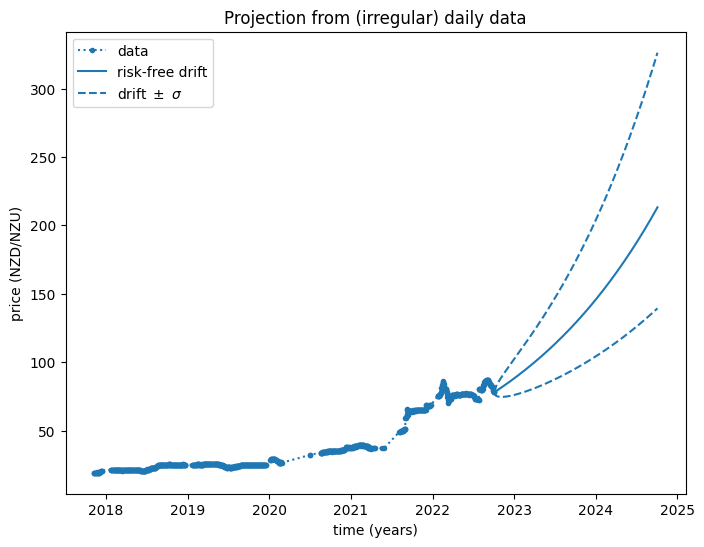

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(spot_date, spot_price, linestyle=':', marker='.', label='data')
ax.plot(proj_spot_date, proj_spot_price, 'C0', label='risk-free drift')
ax.plot(proj_spot_date, proj_spot_price_lo, 'C0--', label='drift$~\pm~\sigma$')
ax.plot(proj_spot_date, proj_spot_price_hi, 'C0--')
ax.set_title("Projection from (irregular) daily data")
ax.set_xlabel('time (years)')
ax.set_ylabel('price (NZD/NZU)')
plt.legend()
plt.show()

In [73]:
source='https://www.epa.govt.nz/assets/Uploads/Documents/Emissions-Trading-Scheme/Reports/Carbon-markets/NZETR-unit-transfers.xlsx'
df_trans = pd.read_excel(source, header=1, parse_dates=[0], skipfooter=2)
df_trans.rename(columns={'Month and Year':'Date'}, inplace=True)

In [74]:
df_trans

,Date,AAU,CER,ERU,RMU,NZU,Total
0,2008-01-01,0,0.0,0,0,0,0
1,2008-02-01,0,0.0,0,0,0,0
2,2008-03-01,0,108.0,0,0,0,108
3,2008-04-01,0,20.0,0,0,0,20
4,2008-05-01,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...
172,2022-05-01,0,0.0,0,0,20605009,20605009
173,2022-06-01,0,0.0,0,0,9829184,9829184
174,2022-07-01,0,0.0,0,0,10569019,10569019
175,2022-08-01,0,0.0,0,0,7936985,7936985


<AxesSubplot: xlabel='Date'>

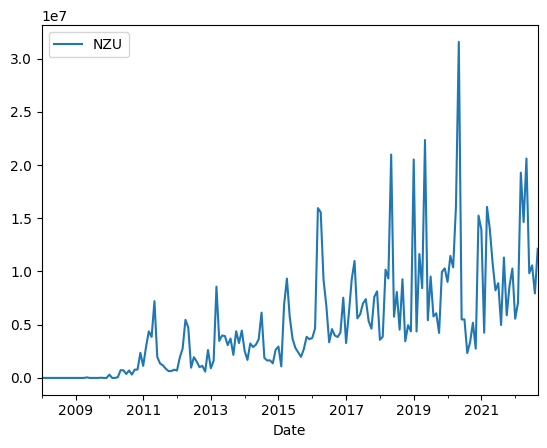

In [76]:
df_trans.plot("Date","NZU")